## Project Description

A hands-on project where the goal is to build a Face Mask Segmentation model which includes building a face detector to locate the position of a face in an image.


## Data Description

**WIDER Face Dataset**

WIDER FACE dataset is a Face Mask Segmentation benchmark dataset, in which images are selected from the publicly available WIDER dataset. This data have 32,203 images and 393,703 faces are labeled with a high degree of variability in scale, pose and occlusion as depicted in the sample images.
In this project, we are using 409 images and around 1000 faces for ease of computation.

We will be using transfer learning on an already trained model to build our segmenter. We will perform **transfer learning** on the **MobileNet** model which is already trained to perform image segmentation. We will need to train the last 6-7 layers and freeze the remaining layers to train the model for face mask segmentation. 

The output of the model is the face mask segmented data which masks the face in an image. We learn to build a face mask segmentation model using Keras supported by Tensorflow.

**Acknowledgment for the datasets**

Acknowledgement:  http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/

Mobile Net paper: https://arxiv.org/pdf/1704.04861.pdf

## Objective

To use "Transfer Learning" of an Object Detector model to detect any object according to the problem in hand. Here, we are particularly interested in detecting faces in a given image.

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.3.0'

In [2]:
# Mounting google drive

from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


#### Import Packages

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create features and labels
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

# Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# To define Loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

#### Load the 'images.npy' file



*   This file contains images with details of bounding boxes



In [4]:
# Reference: https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle = True, **k)

face_data = np.load('/content/gdrive/My Drive/AIML/Projects/images.npy') 

In [5]:
face_data.shape

(409, 2)

Thus, the dataset contains 409 images.

#### Check one sample from the loaded "images.npy" file.

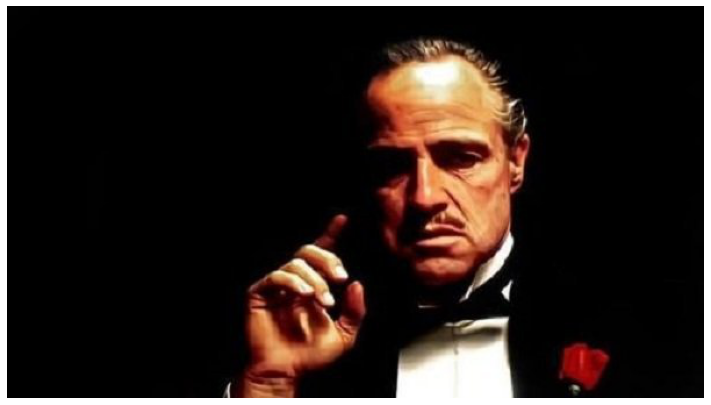

In [6]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(face_data[10][0])
plt.show()

#### Set image dimensions


*   Initialize image height and image width with value: 224



In [7]:
ALPHA = 1

IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

#### Create features and labels


*   Here feature is the image
*   The label is the mask
*   Images will be stored in "X" array
*   Masks will be stored in "masks" array





In [8]:
masks = np.zeros((int(face_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(face_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(face_data.shape[0]):
  img = face_data[index][0]
  img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
  try:
    img = img[:, :, :3]
  except:
    continue
  X[index] = preprocess_input(np.array(img, dtype = np.float32))
  for i in face_data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_HEIGHT)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_WIDTH)
    masks[index][y1:y2, x1:x2] = 1

#### Print the shape of X and mask array

In [9]:
X.shape

(409, 224, 224, 3)

In [10]:
masks.shape

(409, 224, 224)

#### Print a sample training image, image array and its mask

Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


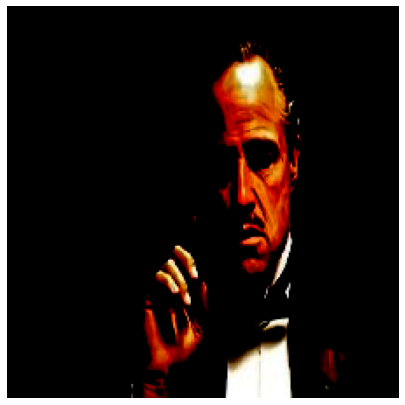

In [11]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

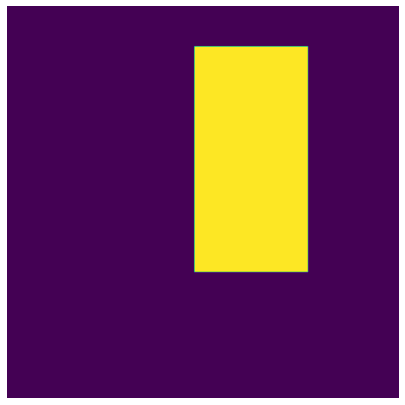

In [12]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(masks[n])

#### Create the model
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers

In [13]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)

#### Call the create_model function

In [14]:
model = create_model(True)

17227776/17225924 [==============================] - 1s 0us/step


#### Print model summary

In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

#### Define dice coefficient function


*   Create a function to calculate dice coefficient



In [16]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

#### Define loss function

In [17]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

#### Compile the model
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [18]:
adam = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

#### Define callbacks
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [19]:
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', save_freq = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

#### Split the data into training and testing
- 400 images in training
- 9 images in testing data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size = 0.022, shuffle = False)

In [21]:
print('Number of images in training data = ', X_train.shape[0])

Number of images in training data =  400


In [22]:
print('Number of images in testing data = ', X_test.shape[0])

Number of images in testing data =  9


In [23]:
print('Numner of labels in training data = ', y_train.shape[0])

Numner of labels in training data =  400


In [24]:
print('Numner of labels in testing data = ', y_test.shape[0])

Numner of labels in testing data =  9


#### Fit the model
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [25]:
model.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_test, y_test))

Streaming output truncated to the last 5000 lines.
307/400 [======================>.......] - ETA: 2:40 - loss: 0.1373 - dice_coefficient: 0.9405
Epoch 00024: loss did not improve from 0.04222
308/400 [======================>.......] - ETA: 2:39 - loss: 0.1369 - dice_coefficient: 0.9406
Epoch 00024: loss did not improve from 0.04222
309/400 [======================>.......] - ETA: 2:37 - loss: 0.1367 - dice_coefficient: 0.9407
Epoch 00024: loss did not improve from 0.04222
310/400 [======================>.......] - ETA: 2:35 - loss: 0.1365 - dice_coefficient: 0.9407
Epoch 00024: loss did not improve from 0.04222
311/400 [======================>.......] - ETA: 2:33 - loss: 0.1362 - dice_coefficient: 0.9408
Epoch 00024: loss did not improve from 0.04222
312/400 [======================>.......] - ETA: 2:32 - loss: 0.1359 - dice_coefficient: 0.9409
Epoch 00024: loss did not improve from 0.04222
313/400 [======================>.......] - ETA: 2:30 - loss: 0.1357 - dice_coefficient: 0.9410
Ep

In [26]:
model.evaluate(X_test, y_test, verbose = 1)

1/1 [==============================] - 0s 1ms/step - loss: 1.0759 - dice_coefficient: 0.5267


[1.0759388208389282, 0.5267057418823242]

#### Get the predicted mask for a sample image

In [27]:
# Load previous model weight
WEIGHTS_FILE = "model_0.04.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred = learned_model.predict(X_test, verbose = 1)

1/1 [==============================] - 0s 2ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


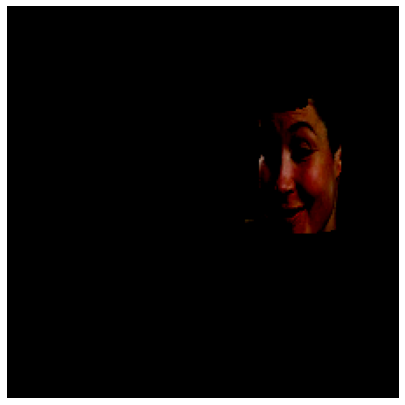

In [35]:
# For a sample image
n = 5
image = cv2.resize(X_test[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0 * (y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:, :, 0] = pred_mask * image[:, :, 0]
image2[:, :, 1] = pred_mask * image[:, :, 1]
image2[:, :, 2] = pred_mask * image[:, :, 2]
out_image = image2

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

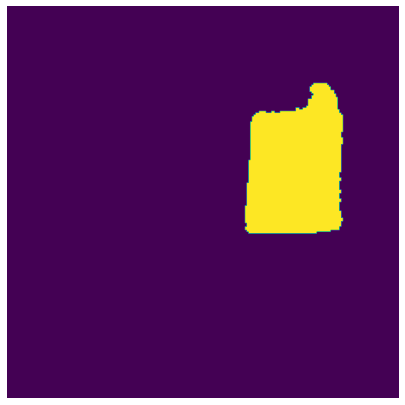

In [36]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

#### Impose the mask on the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


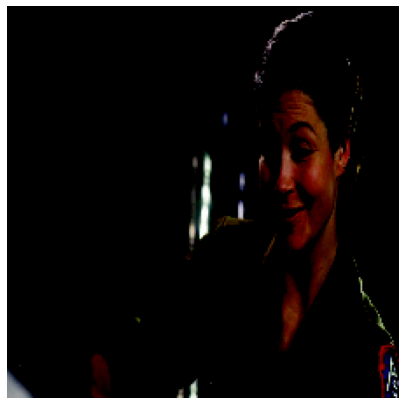

In [37]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_test[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

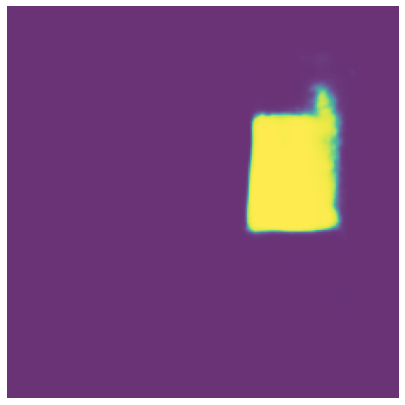

In [38]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

Thus, from this exercise we were able to decipher the following points:
- The idea behind the designing model in order to predict the boundaries (mask) around a face was **how to use Transfer Learning**. Here, we used a pretrained MobileNet and on top it we added the UNET layers to train, fit and evaluate the model
- Here our model was compiled using **binary cross entropy** as loss, **Adam Optimizer** as our optimizer and **Dice Coefficient** as metric
- For callbacks we used **Model Checkpoint**, **Early Stopping** and **ReduceLROnPlateau**
- We had split the given WIDER dataset (a subset of the original one) into two where we had **400 images in training set** and **9 images in test set**
- After training the model for 30 epochs on training set, the best loss that I had acheived was **0.11 on loss and a dice coefficient of 0.95**
- Furthermore, we used model weights (in this case - model_0.04.h5) on our test data to predict the mask around a face
- As seen in the above example (for image = 5 of our test data), our model does a good job in predicting the masks.